### Source: https://www.kaggle.com/code/landlord/numba-cuda-mandelbrot?utm_source=chatgpt.com

In [9]:
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer

In [10]:
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

In [11]:
def mandel_trap(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x, y)
    z = 0.0j
    min_cross = 1e10
    
    for i in range(max_iters):
        z = z*z + c
        # calculate cross-trap distance
        cross_dist = min(abs(z.real), abs(z.imag))
        if i > 1:
            if (cross_dist < min_cross):
                min_cross = cross_dist

    return min_cross

In [12]:
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

In [13]:
def equalize_histogram(image):
    """Apply histogram equalization to the image."""
    flat = image.flatten()
    hist, bins = np.histogram(flat, bins=512, density=True)
    cdf = hist.cumsum() / hist.sum()  # Normalize to [0,1]
    return np.interp(flat, bins[:-1], cdf).reshape(image.shape)

Mandelbrot created in 8.458931 s


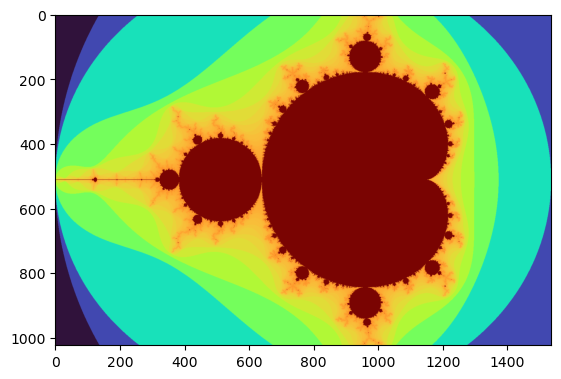

In [14]:
image = np.zeros((1024, 1536), dtype = np.float16)

start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 200) 
dt = timer() - start

image = equalize_histogram(image)

print("Mandelbrot created in %f s" % dt)
imshow(image, cmap='turbo')
show()

Mandelbrot created in 0.137500 s


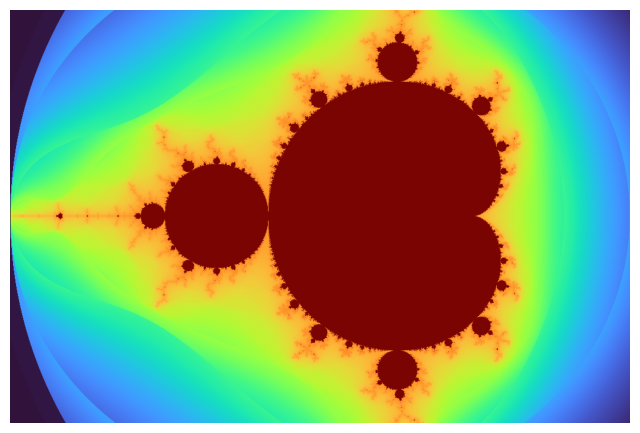

In [48]:
from fractalart.fractal.mandelbrot import *

m = Mandelbrot(-2.0, 1.0, -1.0, 1.0, max_iter=200)
m.resolution = 1024, 1536
start = timer()
m.render()
dt = timer() - start
m.equalize_histogram()
print("Mandelbrot created in %f s" % dt)
m.plot()

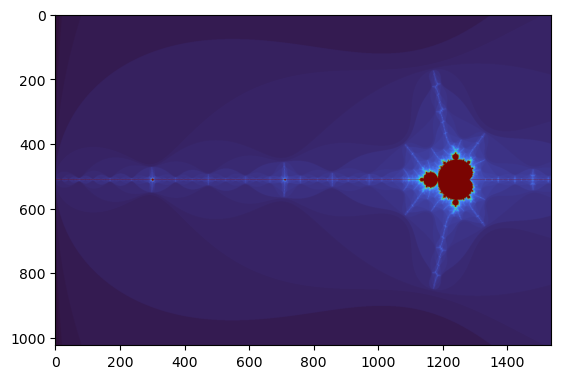

In [17]:
create_fractal(-2.0, -1.7, -0.1, 0.1, image, 200)
#image = equalize_histogram(image)
imshow(image, cmap='turbo')
show()

In [18]:
from numba import jit

@jit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

Mandelbrot created in 0.211082 s


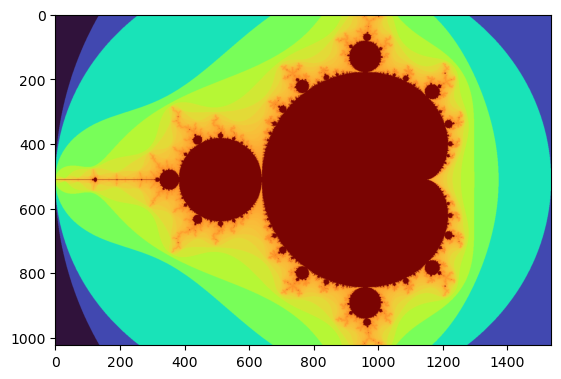

In [20]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 200) 
dt = timer() - start
image = equalize_histogram(image)

print("Mandelbrot created in %f s" % dt)
imshow(image, cmap='turbo')
show()

### Source: chatGPT

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def mandelbrot_numpy(xmin, xmax, ymin, ymax, width, height, max_iter=200):
    # Create complex plane grid (shape = (height, width))
    real = np.linspace(xmin, xmax, width, dtype=np.float64)
    imag = np.linspace(ymin, ymax, height, dtype=np.float64)[:, None]
    c = real + 1j * imag

    z = np.zeros_like(c)
    # output: number of iterations before escape (0..max_iter)
    output = np.zeros(c.shape, dtype=np.int32)

    mask = np.ones(c.shape, dtype=bool)  # points still in computation
    for i in range(1, max_iter + 1):
        z[mask] = z[mask] * z[mask] + c[mask]
        escaped = (np.abs(z) > 2.0) & mask
        output[escaped] = i
        mask &= ~escaped
        if not mask.any():
            break
    # points that never escaped get max_iter
    output[output == 0] = max_iter
    return output

Mandelbrot created in 1.173005 s


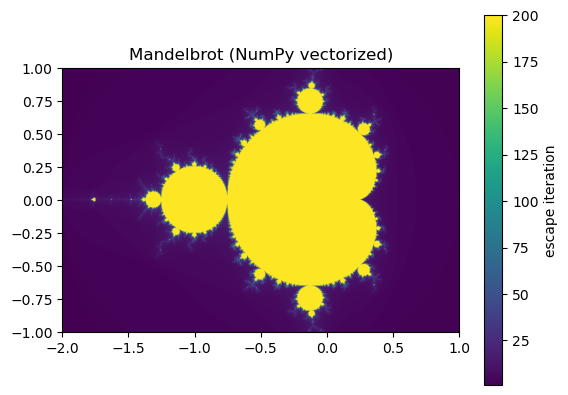

In [23]:
start = timer()
img = mandelbrot_numpy(-2.0, 1.0, -1.0, 1.0, width=1536, height=1024, max_iter=200)
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
plt.imshow(img, extent=[-2,1,-1,1], origin='lower')
plt.colorbar(label='escape iteration')
plt.title("Mandelbrot (NumPy vectorized)")
plt.show()

In [39]:
# mandelbrot_numba.py
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

@njit
def mandel_point(x, y, max_iter):
    c_real = x
    c_imag = y
    z_real = 0.0
    z_imag = 0.0
    for i in range(max_iter):
        # z = z*z + c  (manual complex arithmetic is faster in nopython)
        z_real2 = z_real*z_real - z_imag*z_imag + c_real
        z_imag = 2*z_real*z_imag + c_imag
        z_real = z_real2
        if z_real*z_real + z_imag*z_imag > 4.0:
            return i
            
    return max_iter

@njit(parallel=True)
def mandelbrot_numba(xmin, xmax, ymin, ymax, width, height, max_iter):
    result = np.empty((height, width), dtype=np.int32)
    for j in prange(height):
        y = ymin + (ymax - ymin) * j / (height - 1)
        for i in range(width):
            x = xmin + (xmax - xmin) * i / (width - 1)
            result[j, i] = mandel_point(x, y, max_iter)
    return result

Mandelbrot created in 0.076518 s


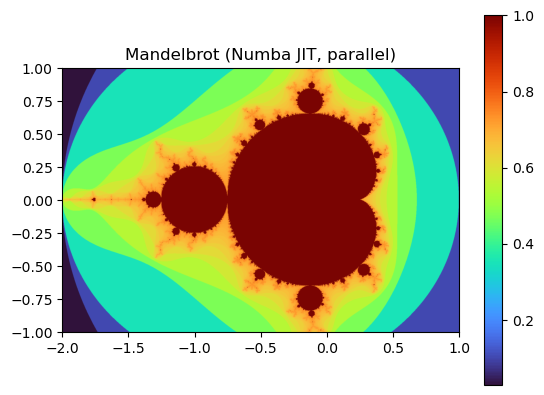

In [41]:
start = timer()
img = mandelbrot_numba(-2.0, 1.0, -1.0, 1.0, 1536, 1024, 200)
dt = timer() - start

img = equalize_histogram(img)

print("Mandelbrot created in %f s" % dt)
plt.imshow(img, extent=[-2,1,-1,1], origin='lower', cmap='turbo')
plt.title("Mandelbrot (Numba JIT, parallel)")
plt.colorbar()
plt.show()

In [42]:
# mandelbrot_numba_optimized.py
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange, float64, int32

@njit(fastmath=True, inline='always')
def mandel_point(c_real, c_imag, max_iter):
    """
    Compute the number of iterations for a single point.
    Inlined + fastmath speeds this up noticeably.
    """
    z_real = 0.0
    z_imag = 0.0
    for n in range(max_iter):
        # z = z^2 + c (manual complex arithmetic)
        zr2 = z_real * z_real
        zi2 = z_imag * z_imag
        if zr2 + zi2 > 4.0:
            return n
        z_imag = 2.0 * z_real * z_imag + c_imag
        z_real = zr2 - zi2 + c_real
    return max_iter

@njit(parallel=True, fastmath=True)
def mandelbrot_numba(xmin, xmax, ymin, ymax, width, height, max_iter):
    """
    Optimized Mandelbrot set generator:
    - Precompute x/y steps to avoid redundant divisions in inner loops.
    - Use prange only on outer loop to maximize parallelism.
    - Inline point function to avoid call overhead.
    """
    result = np.empty((height, width), dtype=np.int32)
    dx = (xmax - xmin) / (width - 1)
    dy = (ymax - ymin) / (height - 1)

    for j in prange(height):
        y = ymin + j * dy
        for i in range(width):
            x = xmin + i * dx
            result[j, i] = mandel_point(x, y, max_iter)

    return result

Mandelbrot created in 0.062598 s


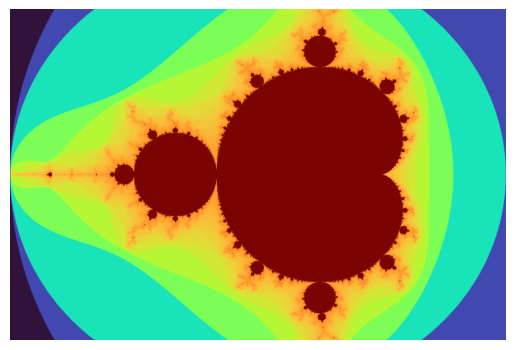

In [45]:
xmin, xmax = -2.0, 1.0
ymin, ymax = -1.0, 1.0
width, height = 1536, 1024
max_iter = 200
start = timer()
image = mandelbrot_numba(xmin, xmax, ymin, ymax, width, height, max_iter)
dt = timer() - start
print("Mandelbrot created in %f s" % dt)
image = equalize_histogram(image)
plt.imshow(image, cmap='turbo', extent=(xmin, xmax, ymin, ymax))
plt.axis('off')
plt.show()